## Assignment: Image recognition
- Alumno 1: Adam Foldvari
- Alumno 2: Mate Lukacs
- Alumno 3: Joseph Tartivel

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [ ]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('/kaggle/input/files/xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [6]:
import json

# Load database
json_file = '/kaggle/input/files/xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [7]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [8]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 19239
Number of validation images: 2138


In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Create base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers
base_model.trainable = False  # Freeze during initial training [1]

# Build new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs

# Data augmentation (keep existing layers)
x = RandomFlip("horizontal_and_vertical")(x)
x = RandomRotation(0.2)(x)
x = RandomZoom(0.2)(x)
x = RandomContrast(0.2)(x)

# Preprocessing for ResNet
x = tf.keras.applications.resnet.preprocess_input(x)  # [3]

# Base model
x = base_model(x, training=False)  # Important for BatchNorm [4]
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(categories), activation='softmax')(x)

model = Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_2             │ (None, 224, 224, 3)    │              0 │ input_layer_7[0][0]    │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_2         │ (None, 224, 224, 3)    │              0 │ random_flip_2[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_2             │ (None, 224, 224, 3)    │              0 │ random_rotation_2[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_contrast_2         │ (None, 224, 224, 3)    │              0 │ random_zoom_2[0][0]    │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 224, 224)       │              0 │ random_contrast_2[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 224, 224)       │              0 │ random_contrast_2[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_8 (GetItem)      │ (None, 224, 224)       │              0 │ random_contrast_2[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_6[0][0],      │
│                           │                        │                │ get_item_7[0][0],      │
│                           │                        │                │ get_item_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 12)             │          6,156 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,642,956 (94.01 MB)

 Trainable params: 1,055,244 (4.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def custom_lr_schedule(epoch):
    base_lr = 1e-4
    warmup_epochs = 5
    
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    
    if epoch % 20 == 0 and epoch != 0:
        return base_lr * 0.5
    
    return base_lr * (0.95 ** epoch)

opt = Adam(
   learning_rate=custom_lr_schedule(0),
   beta_1=0.9,
   epsilon=1e-7,
   clipnorm=1.0)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_callback = LearningRateScheduler(custom_lr_schedule, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True, mode='max')
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, lr_callback, early_stop, terminate]

In [15]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            # Force channels-last format
            images = np.transpose(images, (0, 1, 2, 3))  # Swap width/channel axes
            yield images, labels

In [16]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 64
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [17]:
import math
import numpy as np

# PHASE 1: Train with frozen base model
print('Phase 1: Training with frozen base model')
epochs_phase1 = 40  # Reduce initial epochs since we'll have a second phase
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)

h1 = model.fit(train_generator, steps_per_epoch=train_steps,
              validation_data=valid_generator, validation_steps=valid_steps,
              epochs=epochs_phase1, callbacks=callbacks, verbose=1)

# Save the best model from phase 1
best_idx = int(np.argmax(h1.history['val_accuracy']))
best_value = np.max(h1.history['val_accuracy'])
print('Best validation model (Phase 1): epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

# PHASE 2: Fine-tuning - unfreeze base model layers
print('Phase 2: Fine-tuning ResNet layers')

# Load the best weights from phase 1
model.load_weights('model.keras')

# Unfreeze base model layers for fine-tuning
base_model.trainable = True

# Only unfreeze later layers (keeping early layers frozen)
# Adjust the number based on the specific ResNet variant
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create new callbacks for phase 2
model_checkpoint_phase2 = ModelCheckpoint('model_phase2.keras', monitor='val_accuracy', 
                                          verbose=1, save_best_only=True, mode='max')
early_stop_phase2 = EarlyStopping(monitor='val_accuracy', patience=10, 
                                  verbose=1, restore_best_weights=True, mode='max')
callbacks_phase2 = [model_checkpoint_phase2, early_stop_phase2, terminate]

# Continue training with fine-tuning
epochs_phase2 = 40
h2 = model.fit(train_generator, steps_per_epoch=train_steps,
              validation_data=valid_generator, validation_steps=valid_steps,
              epochs=epochs_phase2, callbacks=callbacks_phase2, verbose=1)

# Find best model from phase 2
best_idx_phase2 = int(np.argmax(h2.history['val_accuracy']))
best_value_phase2 = np.max(h2.history['val_accuracy'])
print('Best validation model (Phase 2): epoch ' + str(best_idx_phase2+1), 
      ' - val_accuracy ' + str(best_value_phase2))

# Combine history for plotting
combined_history = {
    'accuracy': h1.history['accuracy'] + h2.history['accuracy'],
    'val_accuracy': h1.history['val_accuracy'] + h2.history['val_accuracy'],
    'loss': h1.history['loss'] + h2.history['loss'],
    'val_loss': h1.history['val_loss'] + h2.history['val_loss']
}

Phase 1: Training with frozen base model

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/40
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2642 - loss: 2.3478
Epoch 1: val_accuracy improved from -inf to 0.51403, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 784s 3s/step - accuracy: 0.2645 - loss: 2.3468 - val_accuracy: 0.5140 - val_loss: 1.4557 - learning_rate: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/40
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.4848 - loss: 1.5625
Epoch 2: val_accuracy improved from 0.51403 to 0.60009, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 110s 365ms/step - accuracy: 0.4849 - loss: 1.5623 - val_accuracy: 0.6001 - val_loss: 1.1990 - learning_rate: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 6.000000000000001e-05.
Epoch 3/40
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5607 - loss: 1.3112
Epoch 3: val_accuracy improved

<ipython-input-19-15f72862ddc6>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


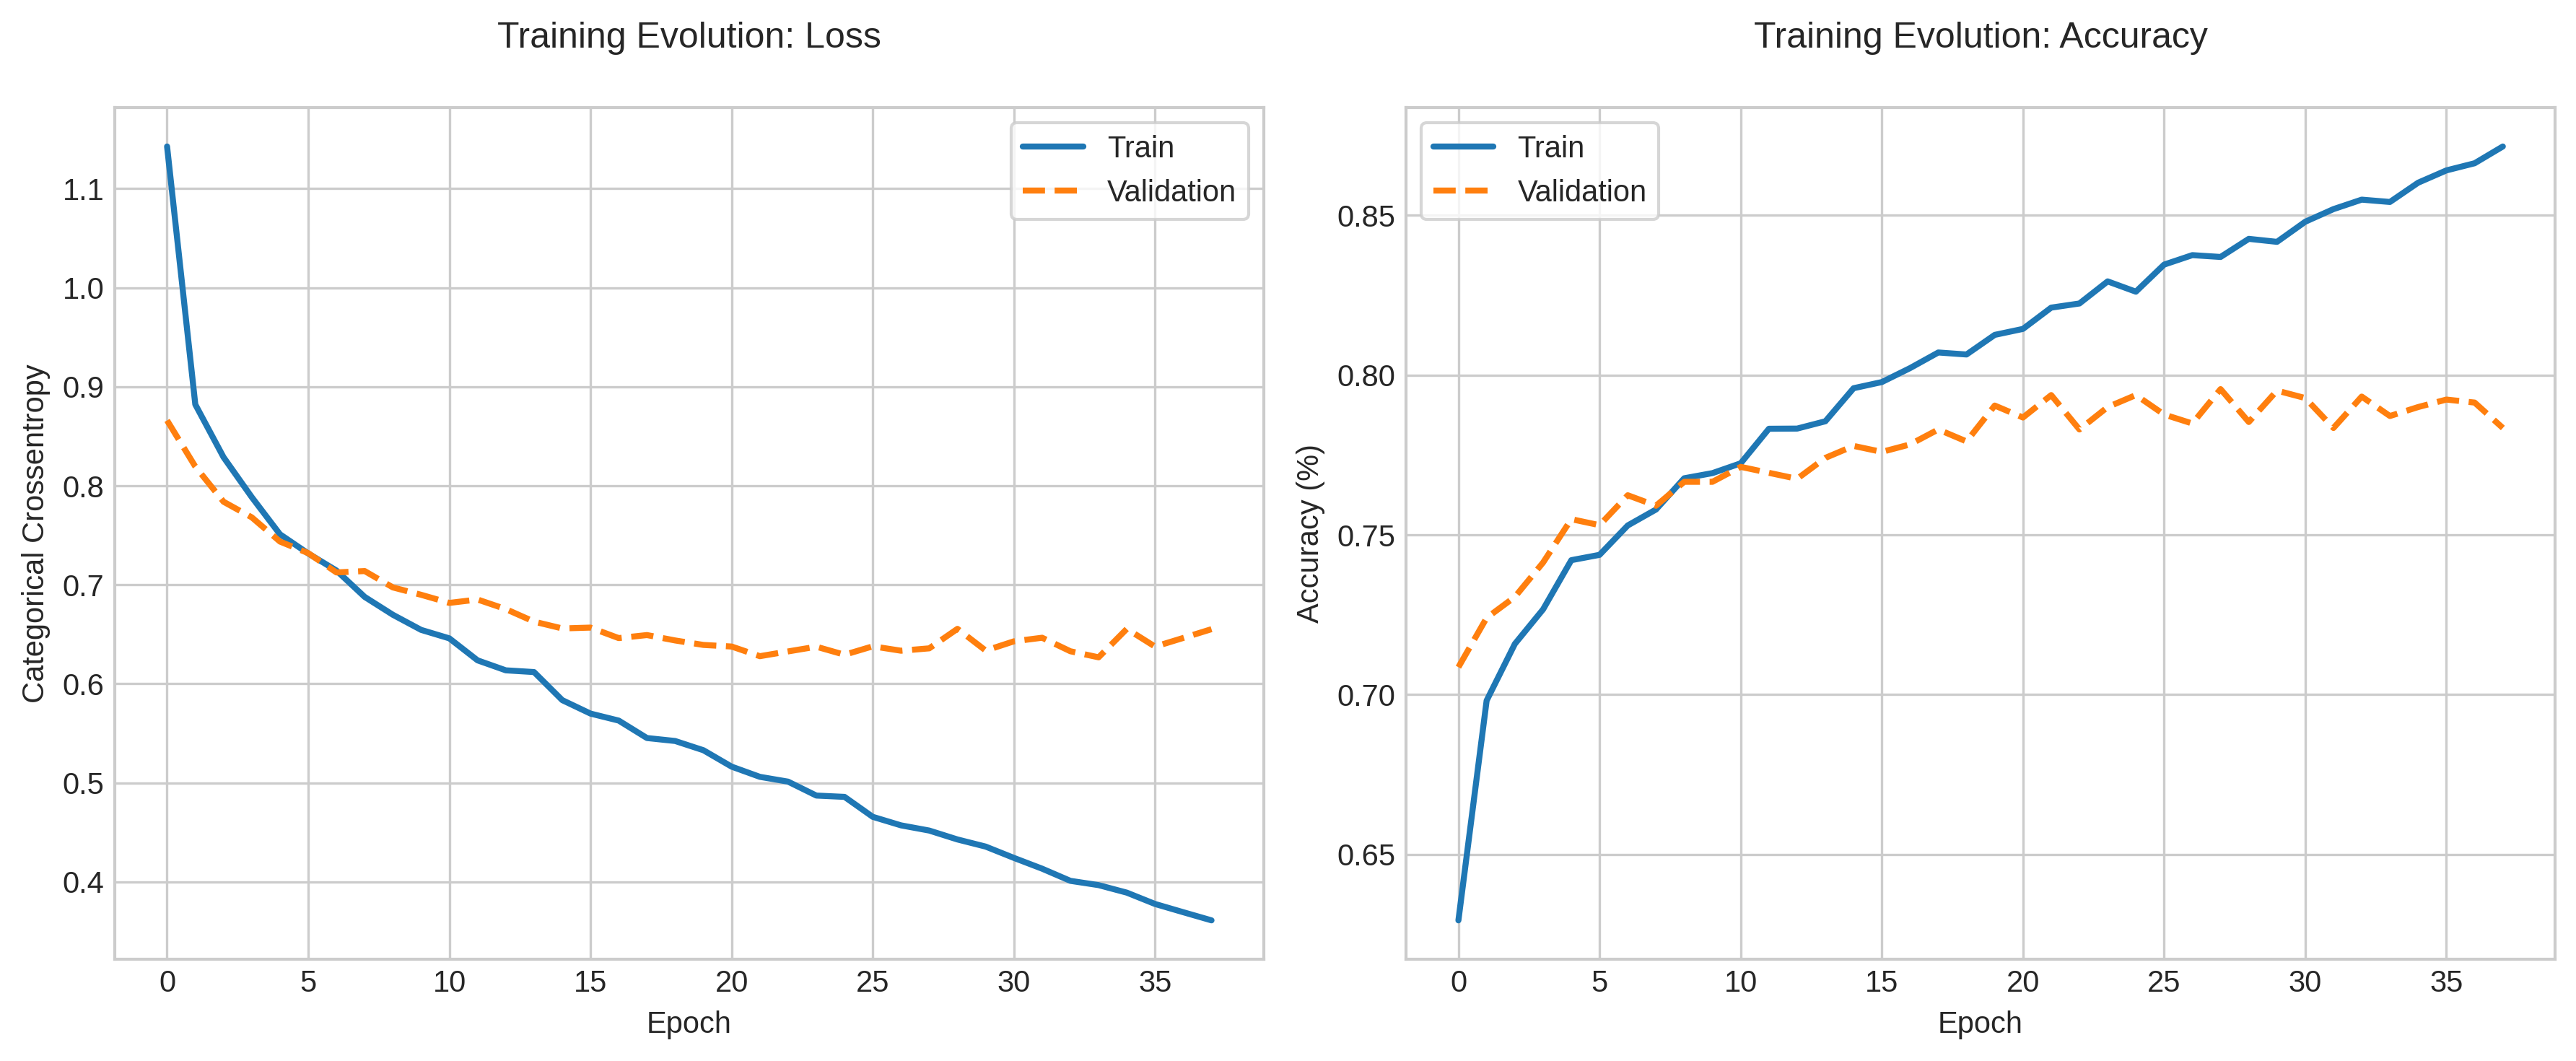

In [19]:
#PLOTS

import matplotlib.pyplot as plt

# Create subplots with custom styling
plt.figure(figsize=(12, 5), dpi=300)
plt.style.use('seaborn-whitegrid')

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(h2.history['loss'], color='#1f77b4', linewidth=2, label='Train')
plt.plot(h2.history['val_loss'], color='#ff7f0e', linewidth=2, linestyle='--', label='Validation')
plt.title('Training Evolution: Loss', fontsize=12, pad=20)
plt.ylabel('Categorical Crossentropy', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(frameon=True, facecolor='white')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(h2.history['accuracy'], color='#1f77b4', linewidth=2, label='Train')
plt.plot(h2.history['val_accuracy'], color='#ff7f0e', linewidth=2, linestyle='--', label='Validation')
plt.title('Training Evolution: Accuracy', fontsize=12, pad=20)
plt.ylabel('Accuracy (%)', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(frameon=True, facecolor='white')

plt.tight_layout()
plt.savefig('training_evolution_2ndPhase.png', bbox_inches='tight', transparent=False)
plt.show()


#### Validation
Compute validation metrics.

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [21]:
import numpy as np

model.load_weights('model_phase2.keras') #, by_name=True
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

<ipython-input-20-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


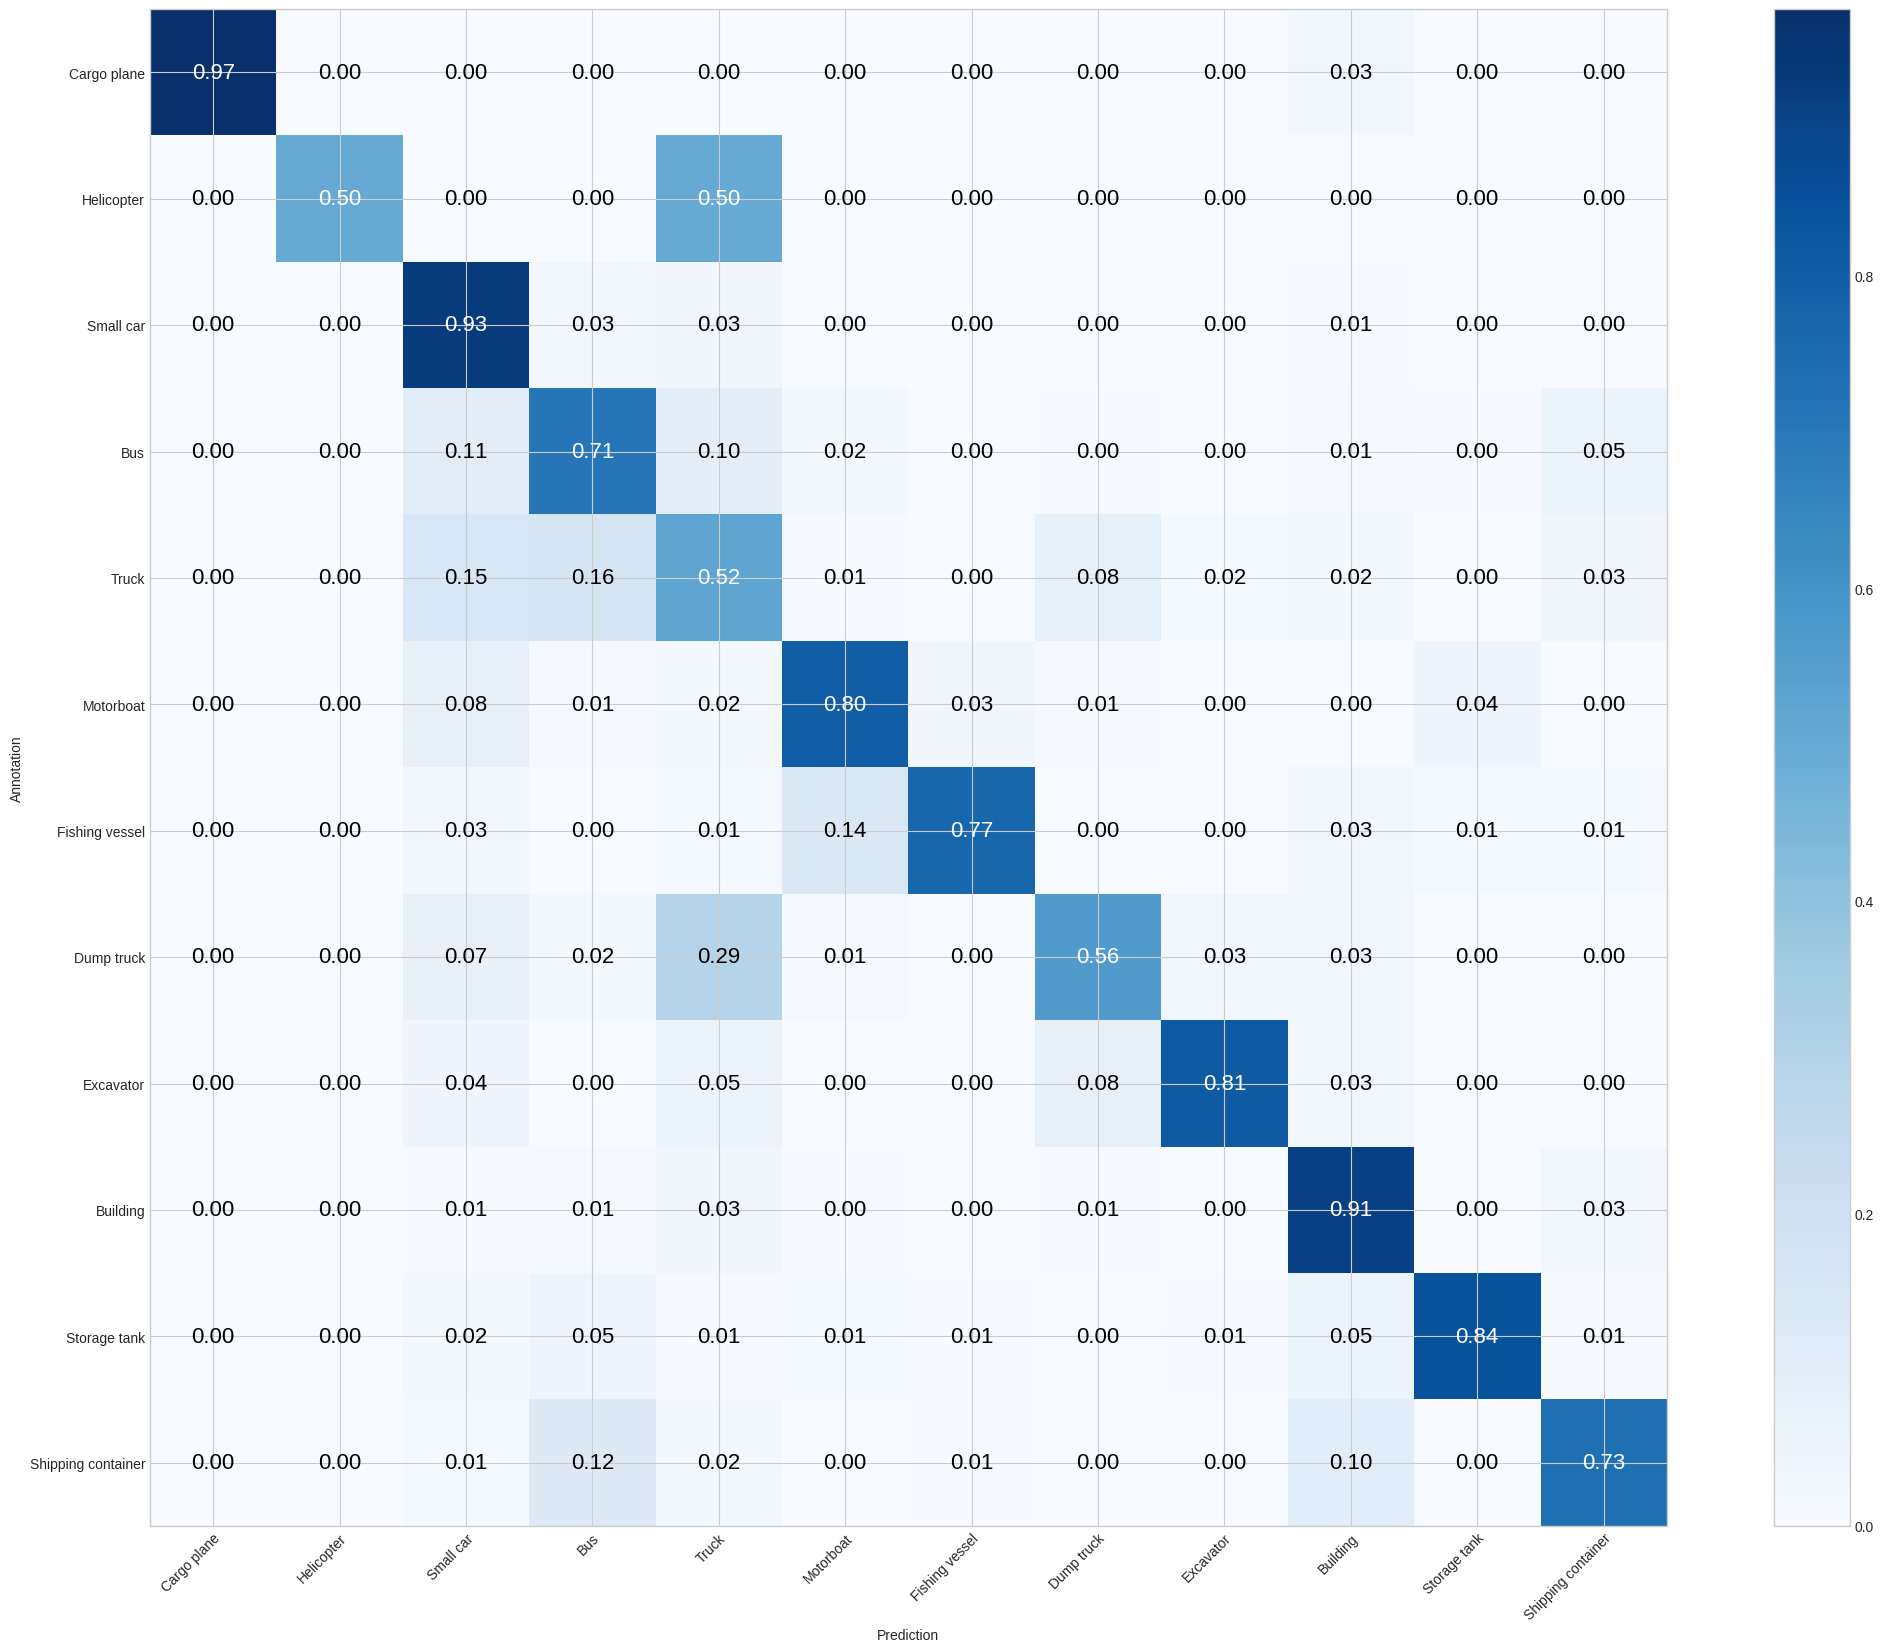

In [22]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [23]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 79.560%
Mean Recall: 75.397%
Mean Precision: 82.133%
> Cargo plane: Recall: 97.059% Precision: 100.000% Specificity: 100.000% Dice: 98.507%
> Helicopter: Recall: 50.000% Precision: 100.000% Specificity: 100.000% Dice: 66.667%
> Small car: Recall: 92.857% Precision: 80.913% Specificity: 94.645% Dice: 86.475%
> Bus: Recall: 70.776% Precision: 63.525% Specificity: 95.362% Dice: 66.955%
> Truck: Recall: 52.075% Precision: 58.723% Specificity: 94.821% Dice: 55.200%
> Motorboat: Recall: 79.775% Precision: 76.344% Specificity: 98.926% Dice: 78.022%
> Fishing vessel: Recall: 76.623% Precision: 90.769% Specificity: 99.709% Dice: 83.099%
> Dump truck: Recall: 56.410% Precision: 66.000% Specificity: 98.318% Dice: 60.829%
> Excavator: Recall: 80.769% Precision: 88.732% Specificity: 99.612% Dice: 84.564%
> Building: Recall: 90.726% Precision: 91.093% Specificity: 97.320% Dice: 90.909%
> Storage tank: Recall: 84.314% Precision: 94.161% Specificity: 99.597% Dice: 88.966%
> Shipping con

#### Testing
Try to improve the results provided in the competition.

In [24]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/files/xview_recognition/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath[18:]+'/'+filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2635


In [25]:
import numpy as np

model.load_weights('model_phase2.keras') #, by_name=True
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    file_name = ann.filename.split('/')[-1]
    image_data = {"image_id": file_name, "filename": file_name, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage('xview_test/' + file_name)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [26]:
with open("/kaggle/working/prediction_final.json", "w") as outfile:
    json.dump(predictions_data, outfile)